# Summary of this notebook

In the [last notebook](./05_nn_modeling.ipynb), we trained Convolutional Neural Networks to read the 6 types of satellite images (RGB, NIR, SWIR1, SWIR2, TEMP1 and NIGHTLIGHTS) and predict whether a given village is in the poorest third of all villages.  Although none of the CNN models performed particulary well on its own - that is, none of the 6 image types is *by itself* strongly informative about poverty - it is likely that the *combination* of the various image types, along with other data available from satellite imagery, will make for good predictions about poverty when properly used in a model.

With this in mind, in this notebook we use the predicted probabilities from the CNN models, along with latitude, longitude, and country data, as features in various models.  We tune hyperparameters with a grid search and select models based on their accuracy and recall scores on the test data.  Finally, once when we have selected our production model, we examine its performance on the validation data that has remained untouched throughout the modeling process.  We find that our production model achieves an absolute accuracy increase of 4.6% and an absolute recall score increase of 11.4% as compared to the baseline model that does not use satellite imagery.  Finally, we evaluate the production model's performance on a per-country basis.

In [1]:
#If using Google Colab and Google Drive, run the following commands

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#REPLACE THIS COMMAND WITH THE APPROPRIATE PATH TO THE "code" FOLDER ON YOUR GOOGLE DRIVE
%cd ./drive/MyDrive/poverty_project/group_project/code

/content/drive/MyDrive/poverty_project/group_project/code


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier


## Data Import

In [4]:
data_path = '../data/NN_results_csvs'

In [5]:
train = pd.read_csv(f"{data_path}/train.csv", index_col='index')
test = pd.read_csv(f"{data_path}/test.csv", index_col='index')
val = pd.read_csv(f"{data_path}/val.csv", index_col='index')

In [6]:
len(train) + len(test) + len(val)

19467

In [7]:
train.head()

,country,year,wealth_index,is_urban,households,latitude,longitude,is_poorest,RGB_prob_is_poorest,SWIR1_prob_is_poorest,TEMP1_prob_is_poorest,NIGHTLIGHTS_prob_is_poorest,NIR_prob_is_poorest,SWIR2_prob_is_poorest
index,,,,,,,,,,,,,,
lesotho_2014_00-254,lesotho,2014.0,0.983558,1.0,24.0,-28.909042,27.936529,0,0.062643,0.127830,0.187977,0.036982,0.071136,0.143754
burkina_faso_2010_00-162,burkina_faso,2010.0,-0.604069,0.0,25.0,11.163129,-3.322228,1,0.399560,0.303285,0.315730,0.656919,0.228373,0.384060
mali_2012_00-381,mali,2012.0,-0.371823,0.0,25.0,11.877264,-6.966146,0,0.326304,0.704798,0.398550,0.193972,0.189569,0.453934
lesotho_2009_00-237,lesotho,2009.0,-0.110702,0.0,23.0,-29.518770,28.033241,0,0.500558,0.450879,0.249609,0.656919,0.346741,0.549889
zimbabwe_2010_00-125,zimbabwe,2010.0,-0.749686,0.0,28.0,-16.217611,30.610455,1,0.321812,0.504179,0.425657,0.656919,0.497873,0.361642


## Exploring the `prob_is_poorest` predictions



In [8]:
#Get a dataframe of just the target and the oredicted probabilities
df = train.iloc[:,7:]
df.head(2)

,is_poorest,RGB_prob_is_poorest,SWIR1_prob_is_poorest,TEMP1_prob_is_poorest,NIGHTLIGHTS_prob_is_poorest,NIR_prob_is_poorest,SWIR2_prob_is_poorest
index,,,,,,,
lesotho_2014_00-254,0,0.062643,0.127830,0.187977,0.036982,0.071136,0.143754
burkina_faso_2010_00-162,1,0.399560,0.303285,0.315730,0.656919,0.228373,0.384060


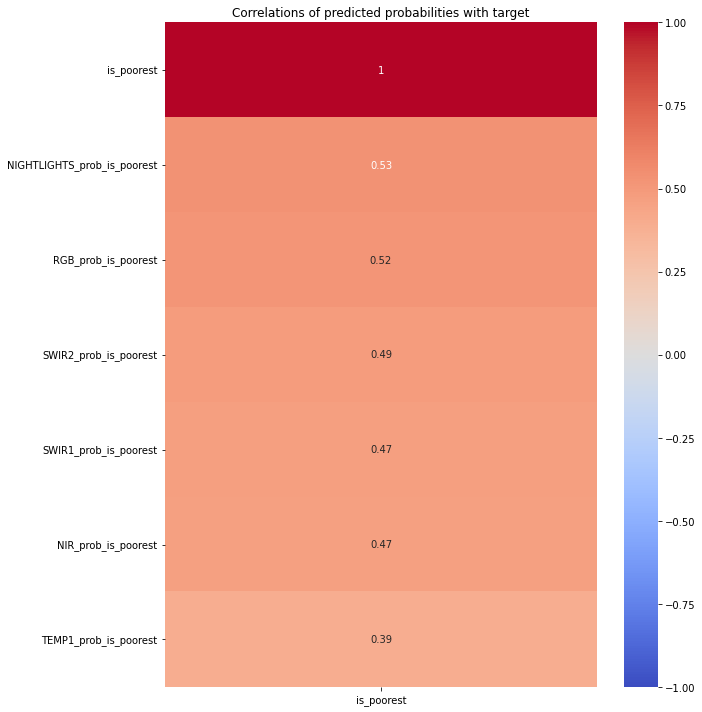

In [9]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr()[['is_poorest']].sort_values(by = 'is_poorest', ascending = False),
           cmap = 'coolwarm',
           vmax = 1,
           vmin = -1,
           annot = True);
plt.title('Correlations of predicted probabilities with target');
plt.tight_layout();
plt.savefig('../presentation_images/pred_prob_corrs_with_target')

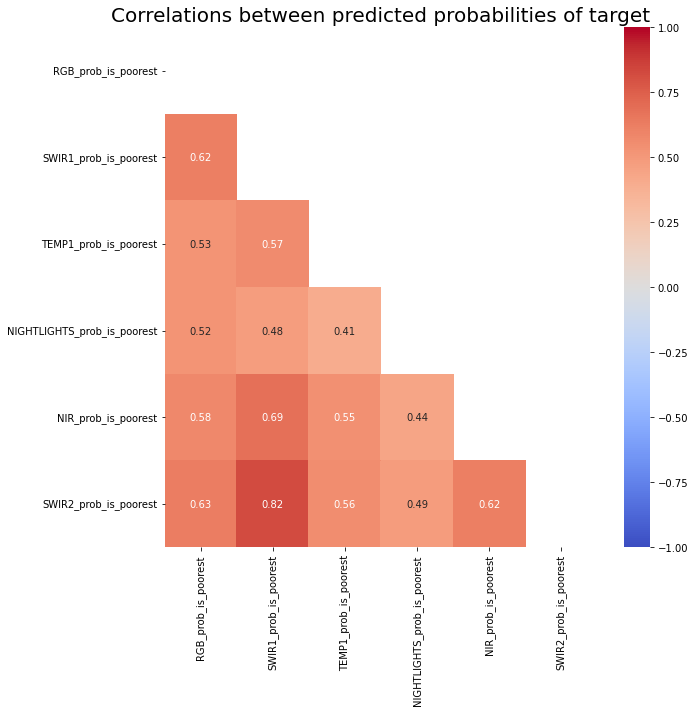

In [10]:
corr = df.drop(columns='is_poorest').corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True

plt.figure(figsize=(10,10));
sns.heatmap(corr,
            cmap = 'coolwarm',
            vmin=-1,
            vmax=1,
            annot=True,
            mask=mask);
plt.title('Correlations between predicted probabilities of target', size=20);
plt.tight_layout();
plt.savefig('../presentation_images/pred_prob_corrs_heatmap')

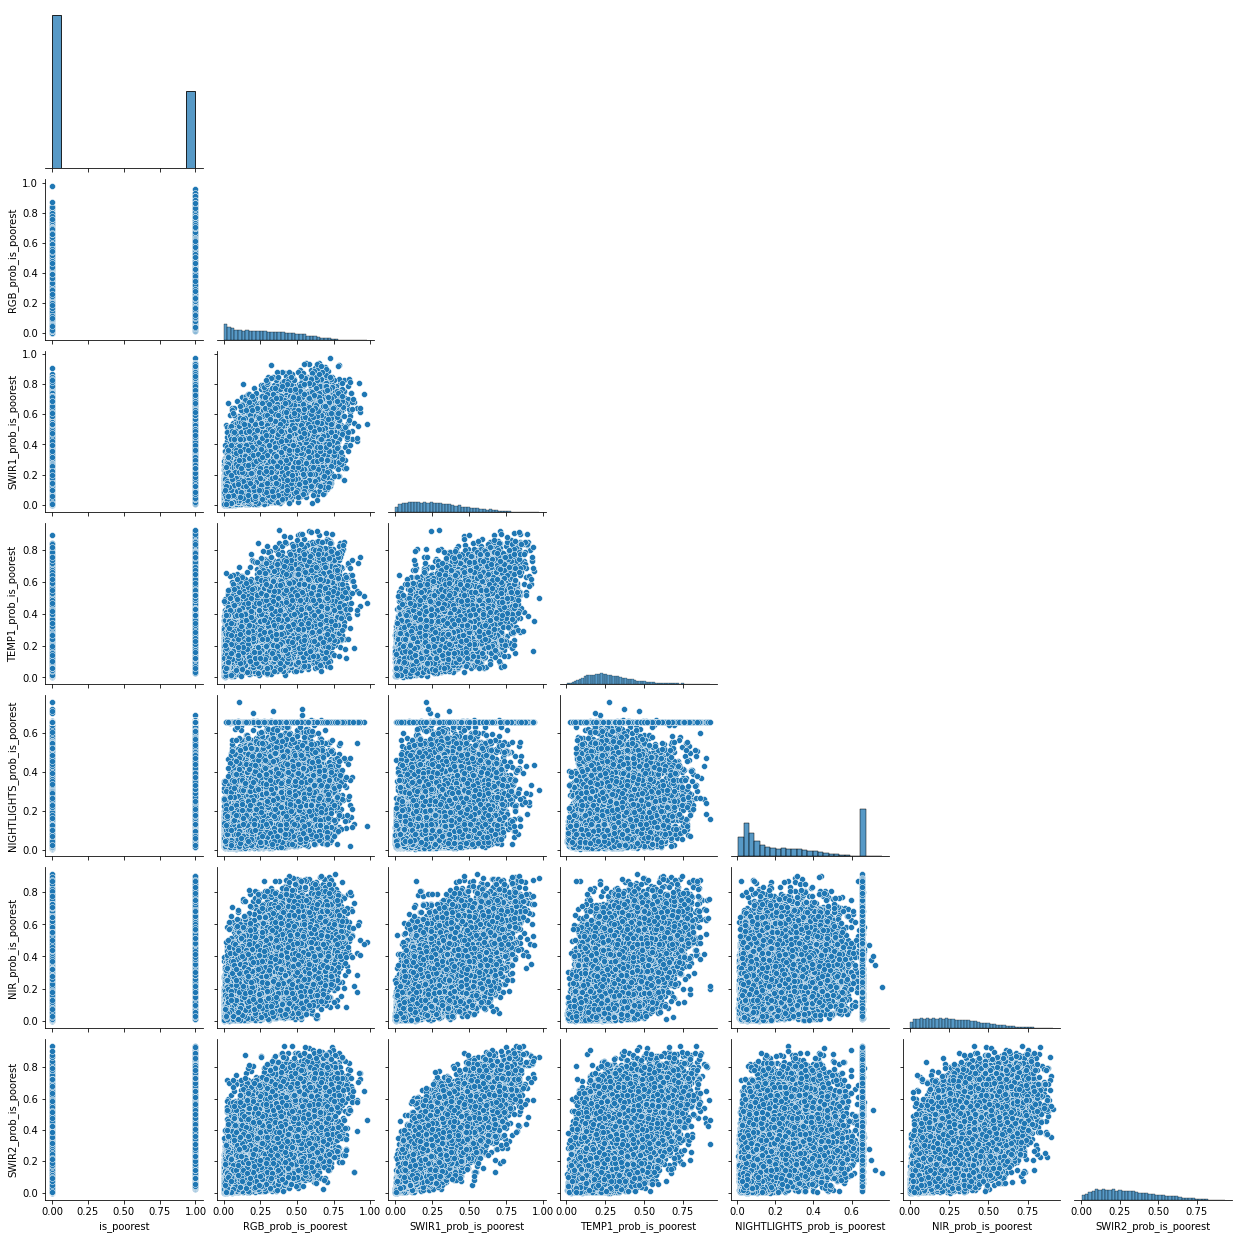

In [11]:
sns.pairplot(df, corner=True)

These results look promising: the predicted probabilities of `is_poorest` (from each of the image types) are not too tightly correlated.  This means that each image type conveys different information about the village it captures.  Thus, there is reason to hope that combining these different predicted probabilities into a single model will yield significantly improved results over using just a single one of them.

# Modeling

## Which variables can we inlude in a model?


In [12]:
list(train.columns)

['country',
 'year',
 'wealth_index',
 'is_urban',
 'households',
 'latitude',
 'longitude',
 'is_poorest',
 'RGB_prob_is_poorest',
 'SWIR1_prob_is_poorest',
 'TEMP1_prob_is_poorest',
 'NIGHTLIGHTS_prob_is_poorest',
 'NIR_prob_is_poorest',
 'SWIR2_prob_is_poorest']

The aim of this project is to predict poverty in villages in Africa using only publicly available satellite information.  The variables `is_urban` (indicator variable for the "village" being inside a relatively urban area) and `households` (the number of households surveyed in that village) might be informative about poverty, but they cannot be determined without collecting additional information that may not be "automatically" available.  While satellite imagery and `country` can be obtained automatically (when given the latitude and longitude coordinates of the village), `is_urban` and `households` cannot.

For this reason, we will not include `is_urban` or `households` as variables in our modeling.  Similarly, we will not include `wealth_index` since it is the variable from which our target `is_poorest` was made and cannot be obtained without extensive surveying.  Finally, we will not include `year` as a predictor, as we want our model to base its predictions only on the location and imagery themselves.

In [13]:
df = train.drop(columns=['is_poorest', 'year', 'wealth_index', 'is_urban', 'households'])
good_cols = list(df.columns)
df.head(2)

,country,latitude,longitude,RGB_prob_is_poorest,SWIR1_prob_is_poorest,TEMP1_prob_is_poorest,NIGHTLIGHTS_prob_is_poorest,NIR_prob_is_poorest,SWIR2_prob_is_poorest
index,,,,,,,,,
lesotho_2014_00-254,lesotho,-28.909042,27.936529,0.062643,0.127830,0.187977,0.036982,0.071136,0.143754
burkina_faso_2010_00-162,burkina_faso,11.163129,-3.322228,0.399560,0.303285,0.315730,0.656919,0.228373,0.384060


In [14]:
X_train = train[good_cols]
X_test = test[good_cols]
X_val = val[good_cols]

y_train = train['is_poorest']
y_test = test['is_poorest']
y_val = val['is_poorest']

In [15]:
#Check that we have the correct variables, e.g. in the test data set
X_test.head(2)

,country,latitude,longitude,RGB_prob_is_poorest,SWIR1_prob_is_poorest,TEMP1_prob_is_poorest,NIGHTLIGHTS_prob_is_poorest,NIR_prob_is_poorest,SWIR2_prob_is_poorest
index,,,,,,,,,
kenya_2014_17-28,kenya,-0.907212,34.582047,0.412457,0.087208,0.472909,0.164352,0.124123,0.223013
kenya_2014_31-11,kenya,0.541424,34.334202,0.389613,0.141361,0.069650,0.326112,0.162249,0.328533


## A function to help with recording results of fitted models

In [16]:
#This function is adapted from Simon Lazarus's "Predicting Housing Prices in Ames, Iowa" project
def results(X_train, X_test, y_train, y_test,
            model, model_name, results_dict):
    '''
    Inputs:
    X_train, X_test: Pandas dataframes
    y_train, y_test: Pandas series
    model_name: What you want this model to be called in the
        outputted pair (a string)
    results_dict: A dictionary of the results that have been recorded
        so far (using this function on other models)
        
    Outputs:
    Returns the inputted results_dict but adds the item
        model_name : [RESULTS]
        where [RESULTS] is a dictionary of the results
        of that model.
    ''' 
    
    
    bp_dict = model.best_params_
    
    results_dict[model_name] = {
        'acc_train' : model.score(X_train, y_train),
        'acc_crossval' : model.best_score_,
        'acc_test' : model.score(X_test, y_test),
        'recall_train' : metrics.recall_score(y_train, model.predict(X_train)),
        'recall_test' : metrics.recall_score(y_test, model.predict(X_test))
                }
    
    return results_dict

## Logistic Regression model

In [17]:
dummify_country = ColumnTransformer(
 transformers=[
     ('ohe', OneHotEncoder(), ['country'])
    ],
    remainder='passthrough'
)

In [18]:
lr_pipe = Pipeline([
    ('dc', dummify_country),
    ('lr', LogisticRegression(max_iter=10_000, random_state=42))
])

In [19]:
lr_pipe_params = {
    'lr__C' : np.logspace(-4,4,80)
}

In [20]:
lr_gs = GridSearchCV(lr_pipe, lr_pipe_params, cv=5, n_jobs=-1)

In [21]:
lr_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('dc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(),
                                                                         ['country'])])),
                                       ('lr',
                                        LogisticRegression(max_iter=10000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'lr__C': array([1.00000000e-04, 1.26260011e-04, 1.59415904e-04, 2.01278538e-04,
       2.54134304e-04, 3.20870000e-04, 4.05130497e-04, 5.1...
       4.68690419e+01, 5.91768575e+01, 7.47167068e+01, 9.43373222e+01,
       1.19110313e+02, 1.50388695e+02, 1.89880782e+02, 2.39743497e+02,
       3.02700165e+02, 3.82189262e+02, 4.82552204e+02, 6.0

In [22]:
lr_gs.best_params_

{'lr__C': 0.2196707090793235}

#### Save the results

In [23]:
#Initialize an empty dictionary of results
results_dict = {}

In [24]:
model = lr_gs
model_name = 'Logistic Regression'

results_dict = results(X_train, X_test, y_train, y_test,
                       model, model_name, results_dict)

results_df = pd.DataFrame.from_dict(results_dict, orient='index')
results_df

,acc_train,acc_crossval,acc_test,recall_train,recall_test
Logistic Regression,0.836587,0.835445,0.820329,0.717844,0.695122


So this model is not particularly overfit, but its accuracy on the test data is only 82%.  Its recall score on the test data is also below 70%.

## Random Forest model

In [25]:
rf_pipe = Pipeline([
    ('dc', dummify_country),
    ('rf', RandomForestClassifier(random_state=42))
])

In [26]:
rf_pipe_params = {
    'rf__n_estimators' : [50, 100, 150, 200],
    'rf__max_depth': [None, 3, 4, 5, 6],
    'rf__min_samples_leaf': [2,4,6]
}

In [27]:
rf_gs = GridSearchCV(rf_pipe, rf_pipe_params, cv=5, n_jobs=-1)

In [28]:
rf_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('dc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(),
                                                                         ['country'])])),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [None, 3, 4, 5, 6],
                         'rf__min_samples_leaf': [2, 4, 6],
                         'rf__n_estimators': [50, 100, 150, 200]})

In [29]:
rf_gs.best_params_

{'rf__max_depth': None, 'rf__min_samples_leaf': 2, 'rf__n_estimators': 200}

#### Save the results

In [30]:
model = rf_gs
model_name = 'Random Forest'

results_dict = results(X_train, X_test, y_train, y_test,
                       model, model_name, results_dict)

results_df = pd.DataFrame.from_dict(results_dict, orient='index')
results_df

,acc_train,acc_crossval,acc_test,recall_train,recall_test
Logistic Regression,0.836587,0.835445,0.820329,0.717844,0.695122
Random Forest,0.976027,0.842123,0.837782,0.951894,0.743902


This model scores about 84% accuracy on the test data, but it looks like it is somewhat overfit.  Would removing the `country` dummies help reduce overfitting and improve scores overall?

# Interlude: Fitting models without `country` data

In [31]:
#Make a "small" version of the data (no country variable to dummify)
X_train_sm = X_train.drop(columns='country')
X_test_sm = X_test.drop(columns='country')
X_val_sm = X_val.drop(columns='country')

In [32]:
#Check that e.g. the test data looks right
X_test_sm.head(2)

,latitude,longitude,RGB_prob_is_poorest,SWIR1_prob_is_poorest,TEMP1_prob_is_poorest,NIGHTLIGHTS_prob_is_poorest,NIR_prob_is_poorest,SWIR2_prob_is_poorest
index,,,,,,,,
kenya_2014_17-28,-0.907212,34.582047,0.412457,0.087208,0.472909,0.164352,0.124123,0.223013
kenya_2014_31-11,0.541424,34.334202,0.389613,0.141361,0.069650,0.326112,0.162249,0.328533


## Fitting a Random Forest model again

In [33]:
rf_pipe_sm = Pipeline([
    ('rf', RandomForestClassifier())
])

In [34]:
rf_gs_sm = GridSearchCV(rf_pipe_sm, rf_pipe_params, cv=5, n_jobs=-1)

In [35]:
rf_gs_sm.fit(X_train_sm, y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [None, 3, 4, 5, 6],
                         'rf__min_samples_leaf': [2, 4, 6],
                         'rf__n_estimators': [50, 100, 150, 200]})

In [36]:
rf_gs_sm.best_params_

{'rf__max_depth': None, 'rf__min_samples_leaf': 4, 'rf__n_estimators': 150}

#### Save the results

In [37]:
model = rf_gs_sm
model_name = 'Random Forest (no Country dummies)'

results_dict = results(X_train_sm, X_test_sm, y_train, y_test,
                       model, model_name, results_dict)

results_df = pd.DataFrame.from_dict(results_dict, orient='index')
results_df

,acc_train,acc_crossval,acc_test,recall_train,recall_test
Logistic Regression,0.836587,0.835445,0.820329,0.717844,0.695122
Random Forest,0.976027,0.842123,0.837782,0.951894,0.743902
Random Forest (no Country dummies),0.945491,0.836986,0.816222,0.902252,0.710366


This model ended up performing worse than the model using `country` data, and it's even more overfit.  Does a Logistic Regression model behave similarly?

## Logistic Regression model with no `country` data

In [38]:
lr_pipe_sm = Pipeline([
    ('lr', LogisticRegression(max_iter=10_000))
])

In [39]:
lr_pipe_params = {
    'lr__C' : np.logspace(-4,4,80)
}

In [40]:
lr_gs_sm = GridSearchCV(lr_pipe_sm, lr_pipe_params, cv=5, n_jobs=-1)

In [41]:
lr_gs_sm.fit(X_train_sm, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('lr',
                                        LogisticRegression(max_iter=10000))]),
             n_jobs=-1,
             param_grid={'lr__C': array([1.00000000e-04, 1.26260011e-04, 1.59415904e-04, 2.01278538e-04,
       2.54134304e-04, 3.20870000e-04, 4.05130497e-04, 5.11517810e-04,
       6.45842443e-04, 8.15440740e-04, 1.02957557e-03, 1.29994222e-03,
       1.64130720e-03, 2.07231465e-03, 2.61650470e-03,...
       4.68690419e+01, 5.91768575e+01, 7.47167068e+01, 9.43373222e+01,
       1.19110313e+02, 1.50388695e+02, 1.89880782e+02, 2.39743497e+02,
       3.02700165e+02, 3.82189262e+02, 4.82552204e+02, 6.09270466e+02,
       7.69264957e+02, 9.71274020e+02, 1.22633068e+03, 1.54836526e+03,
       1.95496614e+03, 2.46834047e+03, 3.11652694e+03, 3.93492726e+03,
       4.96823959e+03, 6.27289986e+03, 7.92016405e+03, 1.00000000e+04])})

In [42]:
lr_gs_sm.best_params_

{'lr__C': 11.568875283162832}

#### Save the results

In [43]:
model = lr_gs_sm
model_name = 'Logistic Regression (no Country dummies)'

results_dict = results(X_train_sm, X_test_sm, y_train, y_test,
                       model, model_name, results_dict)

results_df = pd.DataFrame.from_dict(results_dict, orient='index')
results_df

,acc_train,acc_crossval,acc_test,recall_train,recall_test
Logistic Regression,0.836587,0.835445,0.820329,0.717844,0.695122
Random Forest,0.976027,0.842123,0.837782,0.951894,0.743902
Random Forest (no Country dummies),0.945491,0.836986,0.816222,0.902252,0.710366
Logistic Regression (no Country dummies),0.811073,0.811644,0.778234,0.668884,0.646341


So again, removing the `country` variables did not improve performance.

# Fitting other models with `country` data

## XGBoost Classifier

In [44]:
xgb_pipe = Pipeline([
    ('dc', dummify_country),
    ('xgb', XGBClassifier(n_jobs=-1))
])

In [45]:
xgb_pipe_params = {
    'xgb__n_estimators' : [50, 100, 150, 200],
    'xgb__max_depth': [0, 3, 4, 5, 6],
    'xgb__learning_rate': [.2, .3, .4]
}

In [46]:
xgb_gs = GridSearchCV(xgb_pipe, xgb_pipe_params, cv=5, n_jobs=-1)

In [47]:
xgb_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('dc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(),
                                                                         ['country'])])),
                                       ('xgb', XGBClassifier(n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'xgb__learning_rate': [0.2, 0.3, 0.4],
                         'xgb__max_depth': [0, 3, 4, 5, 6],
                         'xgb__n_estimators': [50, 100, 150, 200]})

In [48]:
xgb_gs.best_params_

{'xgb__learning_rate': 0.2, 'xgb__max_depth': 5, 'xgb__n_estimators': 100}

#### Save the results

In [49]:
model = xgb_gs
model_name = 'XGBoost'

results_dict = results(X_train, X_test, y_train, y_test,
                       model, model_name, results_dict)

results_df = pd.DataFrame.from_dict(results_dict, orient='index')
results_df

,acc_train,acc_crossval,acc_test,recall_train,recall_test
Logistic Regression,0.836587,0.835445,0.820329,0.717844,0.695122
Random Forest,0.976027,0.842123,0.837782,0.951894,0.743902
Random Forest (no Country dummies),0.945491,0.836986,0.816222,0.902252,0.710366
Logistic Regression (no Country dummies),0.811073,0.811644,0.778234,0.668884,0.646341
XGBoost,0.891553,0.848402,0.840862,0.833675,0.762195


This is our best-performing model so far, achieving an accuracy score of over 84% on the test data!

## kNN

In [50]:
knn_pipe = Pipeline([
    ('dc', dummify_country),
    ('ss', StandardScaler(with_mean=False)),
    ('knn', KNeighborsClassifier(  ))
])

In [51]:
knn_pipe_params = {
    'knn__n_neighbors' : [3, 5, 7, 9],
    'knn__weights' : ['uniform', 'distance']
}

In [52]:
knn_gs = GridSearchCV(knn_pipe, knn_pipe_params, cv=5, n_jobs=-1)

In [53]:
knn_gs.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('dc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(),
                                                                         ['country'])])),
                                       ('ss', StandardScaler(with_mean=False)),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [3, 5, 7, 9],
                         'knn__weights': ['uniform', 'distance']})

In [54]:
knn_gs.best_params_

{'knn__n_neighbors': 9, 'knn__weights': 'uniform'}

#### Save the results

In [55]:
model = knn_gs
model_name = 'kNN'

results_dict = results(X_train, X_test, y_train, y_test,
                       model, model_name, results_dict)

results_df = pd.DataFrame.from_dict(results_dict, orient='index')
results_df

,acc_train,acc_crossval,acc_test,recall_train,recall_test
Logistic Regression,0.836587,0.835445,0.820329,0.717844,0.695122
Random Forest,0.976027,0.842123,0.837782,0.951894,0.743902
Random Forest (no Country dummies),0.945491,0.836986,0.816222,0.902252,0.710366
Logistic Regression (no Country dummies),0.811073,0.811644,0.778234,0.668884,0.646341
XGBoost,0.891553,0.848402,0.840862,0.833675,0.762195
kNN,0.856164,0.827169,0.815195,0.770386,0.728659


# Stacked Model

In [56]:
level1_estimators = [('lr', lr_gs.best_estimator_),
                     ('knn', knn_gs.best_estimator_),
                     ('rf', rf_gs.best_estimator_),
                     ('xgb', xgb_gs.best_estimator_)]


stacked_model = StackingClassifier(estimators=level1_estimators,
                                 final_estimator=LogisticRegression(penalty='none'))

In [57]:
stacked_model.fit(X_train, y_train)

StackingClassifier(estimators=[('lr',
                                Pipeline(steps=[('dc',
                                                 ColumnTransformer(remainder='passthrough',
                                                                   transformers=[('ohe',
                                                                                  OneHotEncoder(),
                                                                                  ['country'])])),
                                                ('lr',
                                                 LogisticRegression(C=0.2196707090793235,
                                                                    max_iter=10000,
                                                                    random_state=42))])),
                               ('knn',
                                Pipeline(steps=[('dc',
                                                 ColumnTransformer(remainder='passthrough',
                       

#### Save the results

In [58]:
stacked_results = {}
stacked_results['acc_train'] = stacked_model.score(X_train, y_train)
stacked_results['acc_crossval'] = cross_val_score(stacked_model, X_train, y_train)
stacked_results['acc_test'] = stacked_model.score(X_test, y_test)
stacked_results['recall_train'] = metrics.recall_score(y_train, stacked_model.predict(X_train))
stacked_results['recall_test'] = metrics.recall_score(y_test, stacked_model.predict(X_test))

In [68]:
#Take the mean of the 5 CV scores
stacked_results['acc_crossval'] = stacked_results['acc_crossval'].mean()

In [69]:
results_dict['Stacked Model'] = stacked_results

In [79]:
results_df = pd.DataFrame.from_dict(results_dict, orient='index')
results_df.index.name='model'
results_df

,acc_train,acc_crossval,acc_test,recall_train,recall_test
model,,,,,
Logistic Regression,0.836587,0.835445,0.820329,0.717844,0.695122
Random Forest,0.976027,0.842123,0.837782,0.951894,0.743902
Random Forest (no Country dummies),0.945491,0.836986,0.816222,0.902252,0.710366
Logistic Regression (no Country dummies),0.811073,0.811644,0.778234,0.668884,0.646341
XGBoost,0.891553,0.848402,0.840862,0.833675,0.762195
kNN,0.856164,0.827169,0.815195,0.770386,0.728659
Stacked Model,0.925970,0.848858,0.835729,0.872057,0.740854


This model performed slightly worse than the XGBoost classifier in terms of its accuracy and recall scores on the test data.  So our production model will be the **XGBoost Classifier**.

In [71]:
#Save the model for later use
with open('../models/xgb_production_model1.pkl', 'wb') as f:
    pickle.dump(xgb_gs, f)

In [72]:
#Check that it worked
with open('../models/xgb_production_model1.pkl', 'rb') as f:
    model = pickle.load(f)

#### Export the results

In [80]:
results_df.to_csv('../model_results/final_models.csv', index_label='model')

# Comparing our Production Model to Baselines

In [75]:
model.score(X_val, y_val)

0.8499486125385406

In [76]:
#Get recall score
metrics.recall_score(y_val, model.predict(X_val))

0.7859531772575251

This model achieved 85.0% accuracy on our unused validation data.  This is a very good score considering the difficulty of the problem, and it represents an 18.3% absolute increase in accuracy compared to the null model and a 4.6% absolute increase in accuracy over the baseline Random Forest model's validation accuracy score of 80.4%.

However, the biggest improvement of our production model over the baseline model is its recall score.  The null model has a recall score of 0%, and the baseline Random Forest model has a recall score of 67.2% on the validation data.  However, our production model achieves a recall score of 78.6%, representing an absolute increase of 11.4% over the baseline model that does not use satellite imagery.  

This means that by employing satellite imagery, our production model can catch almost four-fifths of all villages in extreme poverty by knowing nothing other than the village's geographic coordinates (by deducing the country and using publicly available imagery).  It is also not overly sensitive, as its overall accuracy score is still 85%.

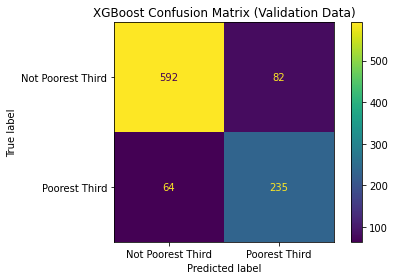

In [81]:
ConfusionMatrixDisplay.from_estimator(model, X_val, y_val, display_labels=['Not Poorest Third', 'Poorest Third'])
plt.title(f'XGBoost Confusion Matrix (Validation Data)');
plt.tight_layout();
plt.savefig(f'../presentation_images/XGBoost_Confusion_Matrix.png')

# Examining the Production Model's Predictions

Let's examine those cases where our production model predicted a false positive or a false negative, as well as those where it correctly predicted a positive or a negative.  Throughout, we will use the validation data that was not used during the modeling process.

In [82]:
val.head(2)

,country,year,wealth_index,is_urban,households,latitude,longitude,is_poorest,RGB_prob_is_poorest,NIR_prob_is_poorest,SWIR1_prob_is_poorest,SWIR2_prob_is_poorest,TEMP1_prob_is_poorest,NIGHTLIGHTS_prob_is_poorest
index,,,,,,,,,,,,,,
benin_2012_00-615,benin,2012.0,1.306931,0.0,21.0,6.384848,2.478482,0,0.049109,0.017400,0.074836,0.055886,0.036021,0.054802
rwanda_2010_00-87,rwanda,2010.0,1.076257,1.0,26.0,-1.953650,30.139626,0,0.038193,0.043351,0.029069,0.014364,0.076905,0.050861


In [83]:
val['model_preds'] = model.predict(X_val)

In [84]:
#Check that the model's predictions were merged in correctly
#This should give the same accuracy as before
metrics.accuracy_score(val['is_poorest'], val['model_preds'])

0.8499486125385406

In [85]:
negatives = val[val['is_poorest']==0]
positives = val[val['is_poorest']==1]

false_negatives = val[(val['is_poorest']==1) & (val['model_preds']==0)]
false_positives = val[(val['is_poorest']==0) & (val['model_preds']==1)]
true_positives = val[(val['is_poorest']==1) & (val['model_preds']==1)]
true_negatives = val[(val['is_poorest']==0) & (val['model_preds']==0)]

#### Get the names of the countries as a dictionary

In [86]:
country_names = pd.DataFrame(val['country'].value_counts()).apply(lambda row : row.index.str.capitalize())
country_names.loc['burkina_faso'] = 'Burkina Faso'
country_names.loc['sierra_leone'] = 'Sierra Leone'
country_names.loc['democratic_republic_of_congo'] = 'Democratic Republic of Congo'
country_names.loc['cote_d_ivoire'] = "Côte d'Ivoire"

In [87]:
country_names_dict = {x : country_names['country'][x] for x in country_names.index}
country_names_dict

{'kenya': 'Kenya',
 'malawi': 'Malawi',
 'tanzania': 'Tanzania',
 'nigeria': 'Nigeria',
 'mozambique': 'Mozambique',
 'burkina_faso': 'Burkina Faso',
 'rwanda': 'Rwanda',
 'benin': 'Benin',
 'zimbabwe': 'Zimbabwe',
 'ethiopia': 'Ethiopia',
 'lesotho': 'Lesotho',
 'uganda': 'Uganda',
 'angola': 'Angola',
 'senegal': 'Senegal',
 'mali': 'Mali',
 'cameroon': 'Cameroon',
 'zambia': 'Zambia',
 'togo': 'Togo',
 'sierra_leone': 'Sierra Leone',
 'ghana': 'Ghana',
 'guinea': 'Guinea',
 'democratic_republic_of_congo': 'Democratic Republic of Congo',
 'cote_d_ivoire': "Côte d'Ivoire"}

#### Get the number of observations from each country, in the false negatives, false positives, all negatives, and all positives

In [88]:
fn_country_counts = false_negatives['country'].value_counts()
fp_country_counts = false_positives['country'].value_counts()
tn_country_counts = true_negatives['country'].value_counts()
tp_country_counts = true_positives['country'].value_counts()

negative_country_counts = negatives['country'].value_counts()
positive_country_counts = positives['country'].value_counts()

In [89]:
negative_countries_df = pd.DataFrame(negative_country_counts)
positive_countries_df = pd.DataFrame(positive_country_counts)
negative_countries_df.rename(columns={'country':'total'}, inplace=True)
positive_countries_df.rename(columns={'country':'total'}, inplace=True)
negative_countries_df.head(3)

,total
kenya,80
nigeria,73
tanzania,55


In [90]:
# True negatives and *false positives* can only occur among observations that were *actually negative*
negative_countries_df['true_negatives'] = tn_country_counts
negative_countries_df['false_positives'] = fp_country_counts

# True positives and *false negatives* can only occur among observations that were *actually positive*
positive_countries_df['true_positives'] = tp_country_counts
positive_countries_df['false_negatives'] = fn_country_counts

#This will create a NaN in the "False Negatives" column for each country with no false negatives
#(and similarly for false positives).  So we should fill in all NaN's with 0.
negative_countries_df.fillna(0, inplace=True)
positive_countries_df.fillna(0, inplace=True)
negative_countries_df.head(3)

,total,true_negatives,false_positives
kenya,80,75.0,5.0
nigeria,73,72.0,1.0
tanzania,55,43.0,12.0


In [91]:
positive_countries_df['tp_rate'] = positive_countries_df.apply(lambda row : row['true_positives'] / row['total'], axis=1)
positive_countries_df['fn_rate'] = positive_countries_df.apply(lambda row : row['false_negatives'] / row['total'], axis=1)

negative_countries_df['tn_rate'] = negative_countries_df.apply(lambda row : row['true_negatives'] / row['total'], axis=1)
negative_countries_df['fp_rate'] = negative_countries_df.apply(lambda row : row['false_positives'] / row['total'], axis=1)

#Examine the false positive rates (among negative observations)
negative_countries_df.head()

,total,true_negatives,false_positives,tn_rate,fp_rate
kenya,80,75.0,5.0,0.937500,0.062500
nigeria,73,72.0,1.0,0.986301,0.013699
tanzania,55,43.0,12.0,0.781818,0.218182
benin,40,40.0,0.0,1.000000,0.000000
malawi,37,26.0,11.0,0.702703,0.297297


In [92]:
#Examine the false negative rates (among positive observations)
positive_countries_df.head()

,total,true_positives,false_negatives,tp_rate,fn_rate
malawi,54,48.0,6.0,0.888889,0.111111
tanzania,28,25.0,3.0,0.892857,0.107143
ethiopia,25,24.0,1.0,0.960000,0.040000
rwanda,23,19.0,4.0,0.826087,0.173913
mozambique,21,21.0,0.0,1.000000,0.000000


In [93]:
#Get the proportions of observations that come from each country (for positives and negatives separately)
#This will be useful for plotting results with widths proportional to 
num_positives = len(positives)
positive_countries_df['proportion_from_country'] = positives['country'].value_counts()/len(positives)

num_negatives = len(negatives)
negative_countries_df['proportion_from_country'] = negatives['country'].value_counts()/len(negatives)

#Look at the countries with the fewer positive observations
positive_countries_df.sort_values('proportion_from_country').head()

,total,true_positives,false_negatives,tp_rate,fn_rate,proportion_from_country
ghana,1,0.0,1.0,0.000000,1.000000,0.003344
senegal,3,1.0,2.0,0.333333,0.666667,0.010033
benin,4,1.0,3.0,0.250000,0.750000,0.013378
mali,4,1.0,3.0,0.250000,0.750000,0.013378
nigeria,4,1.0,3.0,0.250000,0.750000,0.013378


#### Plot the False Positive, False Negaitve, True Positive, and True Negative rates

In [94]:
#Make lists of widths for plotting, based on proportions from each country
tp_widths = list(positive_countries_df.sort_values('tp_rate')['proportion_from_country'])
fn_widths = list(positive_countries_df.sort_values('fn_rate')['proportion_from_country'])
tn_widths = list(negative_countries_df.sort_values('tn_rate')['proportion_from_country'])
fp_widths = list(negative_countries_df.sort_values('fp_rate')['proportion_from_country'])

fn_rates = list(positive_countries_df['fn_rate'].sort_values())
fp_rates = list(negative_countries_df['fp_rate'].sort_values())
tp_rates = list(positive_countries_df['tp_rate'].sort_values())
tn_rates = list(negative_countries_df['tn_rate'].sort_values())

fn_labels = list(positive_countries_df['fn_rate'].sort_values().index)
fn_labels = [country_names_dict[x] for x in fn_labels]
fp_labels = list(negative_countries_df['fp_rate'].sort_values().index)
fp_labels = [country_names_dict[x] for x in fp_labels]
tp_labels = list(positive_countries_df['tp_rate'].sort_values().index)
tp_labels = [country_names_dict[x] for x in tp_labels]
tn_labels = list(negative_countries_df['tn_rate'].sort_values().index)
tn_labels = [country_names_dict[x] for x in tn_labels]

num_pos_countries = len(positives['country'].unique())
num_neg_countries = len(negatives['country'].unique())

fn_country_counts = [ int(x * len(positives)) for x in positive_countries_df.sort_values('fn_rate')['proportion_from_country'] ]
fp_country_counts = [ int(x * len(negatives)) for x in negative_countries_df.sort_values('fp_rate')['proportion_from_country'] ]
tp_country_counts = [ int(x * len(positives)) for x in positive_countries_df.sort_values('tp_rate')['proportion_from_country'] ]
tn_country_counts = [ int(x * len(negatives)) for x in negative_countries_df.sort_values('tn_rate')['proportion_from_country'] ]

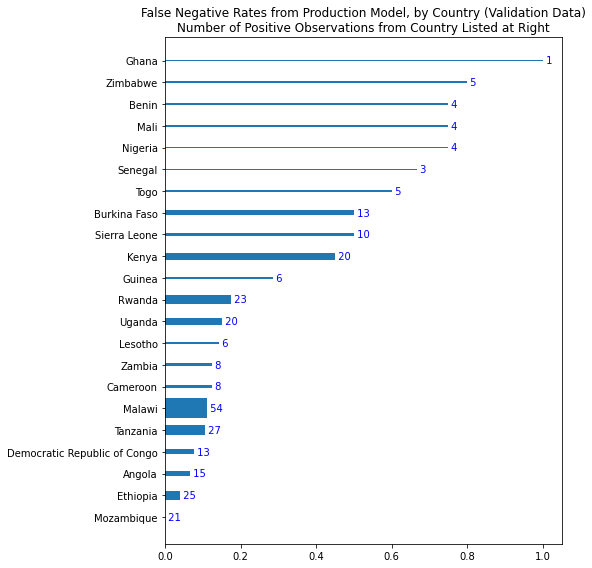

In [95]:
#Plot the false negatives
fig, ax = plt.subplots(1,1,figsize=(8,8))

ax.barh( np.linspace(1, num_pos_countries, num_pos_countries), 
        fn_rates,
        height = [x*5 for x in fn_widths], 
        tick_label = fn_labels
        )
ax.set_title('False Negative Rates from Production Model, by Country (Validation Data)\nNumber of Positive Observations from Country Listed at Right');

for i, (v, x) in enumerate(zip(fn_country_counts, fn_rates)):
    ax.text(x, i+1, " "+str(v), color='blue', va='center')

plt.tight_layout();
plt.savefig('../presentation_images/false_negatives_by_country.png');

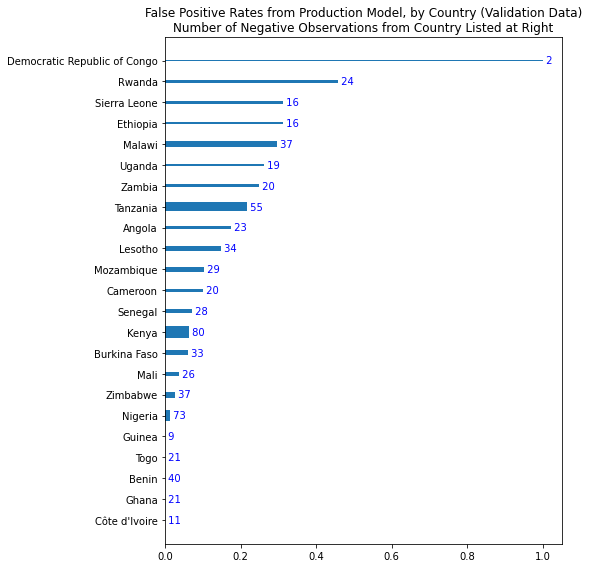

In [96]:
#Plot the false positives
fig, ax = plt.subplots(1,1,figsize=(8,8))

ax.barh( np.linspace(1, num_neg_countries, num_neg_countries), 
        fp_rates,
        height = [x*5 for x in fp_widths], 
        tick_label = fp_labels
        )
ax.set_title('False Positive Rates from Production Model, by Country (Validation Data)\nNumber of Negative Observations from Country Listed at Right');

for i, (v, x) in enumerate(zip(fp_country_counts, fp_rates)):
    ax.text(x, i+1, " "+str(v), color='blue', va='center')

plt.tight_layout();
plt.savefig('../presentation_images/false_positives_by_country.png');

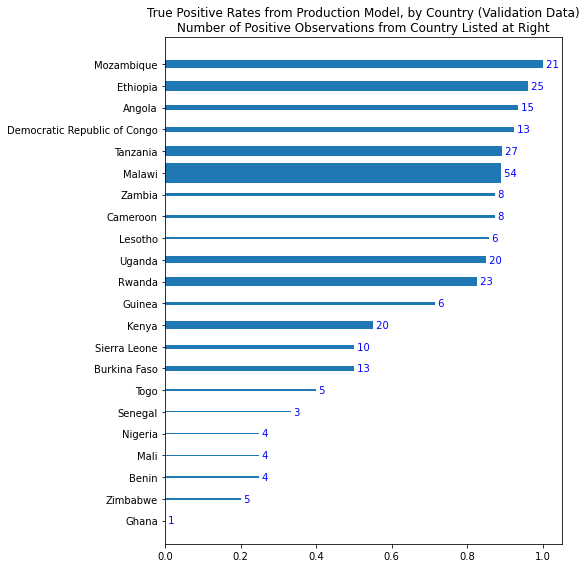

In [97]:
#Plot the true positives
fig, ax = plt.subplots(1,1,figsize=(8,8))

ax.barh( np.linspace(1, num_pos_countries, num_pos_countries), 
        tp_rates,
        height = [x*5 for x in tp_widths], 
        tick_label = tp_labels
        )
ax.set_title('True Positive Rates from Production Model, by Country (Validation Data)\nNumber of Positive Observations from Country Listed at Right');

for i, (v, x) in enumerate(zip(tp_country_counts, tp_rates)):
    ax.text(x, i+1, " "+str(v), color='blue', va='center')

plt.tight_layout();
plt.savefig('../presentation_images/true_positives_by_country.png');

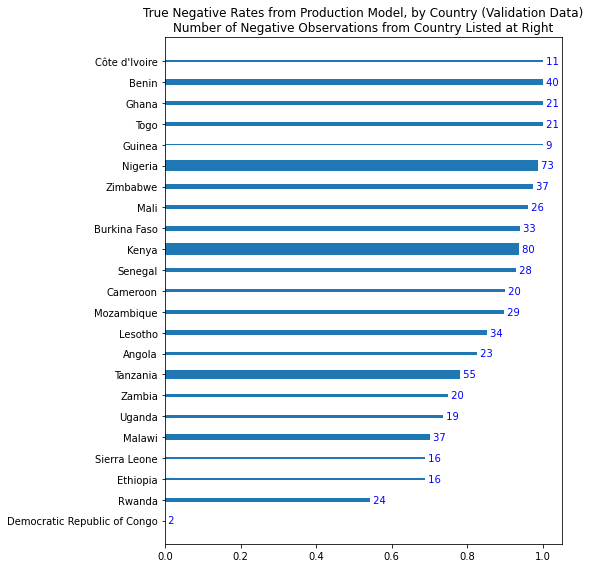

In [98]:
#Plot the true negatives
fig, ax = plt.subplots(1,1,figsize=(8,8))

ax.barh( np.linspace(1, num_neg_countries, num_neg_countries), 
        tn_rates,
        height = [x*5 for x in tn_widths], 
        tick_label = tn_labels
        )
ax.set_title('True Negative Rates from Production Model, by Country (Validation Data)\nNumber of Negative Observations from Country Listed at Right');

for i, (v, x) in enumerate(zip(tn_country_counts, tn_rates)):
    ax.text(x, i+1, " "+str(v), color='blue', va='center')

plt.tight_layout();
plt.savefig('../presentation_images/true_negatives_by_country.png');

### What the by-country results mean

As we can see, despite the model's 85% accuracy score and 79% recall score, there are some countries wherein the model has a very high false positive or false negative rate.  For example, the model has a 100% false negative rate in Ghana!  While this may at first seem alarming, it is much less so when one notices that *there is only one village in the entire validation data set that is both in Ghana and among the poorest third of all villages*!  Thus, this "100% false negative rate" simply means that the model predicted this *one* village incorrectly.  Meanwhile, we find that the model's *false positive* rate in Ghana is *zero percent*: among the 21 villages in Ghana that are *not* in the poorest third of all villages, the model predicts *all of them* correctly.

Similar explanations hold for other countries where the model had a high false negative rate; for example, the 80% false negative rate among the *5 examples of villages from Zimbabwe that are in the poorest third of all villages* is counterbalanced by the tiny 2.7% false positive rate among the 37 villages in Zimbabwe that are *not* in the poorest third of all villages.:

In [100]:
negative_countries_df.loc['zimbabwe']

total                      37.000000
true_negatives             36.000000
false_positives             1.000000
tn_rate                     0.972973
fp_rate                     0.027027
proportion_from_country     0.054896
Name: zimbabwe, dtype: float64

Similar remarks also apply to those countries where the model has a high false positive rate: While the model has a 100% false positive rate among *just 2 cases* in the Democractic Republic of Congo (DRC), among the positive cases it has a false negative rate of merely 7.7%:

In [102]:
positive_countries_df.loc['democratic_republic_of_congo']

total                      13.000000
true_positives             12.000000
false_negatives             1.000000
tp_rate                     0.923077
fn_rate                     0.076923
proportion_from_country     0.043478
Name: democratic_republic_of_congo, dtype: float64

Thus, although the model may have high false positive / false negative rates in some countries that had only a few true negatives / true positives (respectively), it makes up for this fact by having much lower false negative / false positive rates (respectively) among the remainder of the villages in those countries.

Furthermore, it is *not* the case that the model simply learns to guess a village's wealth or poverty based on the name of the country in which it is located.  For example, the model achieves a true positive rate of 87.5% *and* a true negative rate of 90% in Cameroon:

In [104]:
positive_countries_df.loc['cameroon']

total                      8.000000
true_positives             7.000000
false_negatives            1.000000
tp_rate                    0.875000
fn_rate                    0.125000
proportion_from_country    0.026756
Name: cameroon, dtype: float64

In [103]:
negative_countries_df.loc['cameroon']

total                      20.000000
true_negatives             18.000000
false_positives             2.000000
tn_rate                     0.900000
fp_rate                     0.100000
proportion_from_country     0.029674
Name: cameroon, dtype: float64

Even better, in Mozambique, the model achieves a true positive rate of **100%** among 21 villages in the poorest third and a true negative rate of **89.7%** among 29 villages:

In [105]:
positive_countries_df.loc['mozambique']

total                      21.000000
true_positives             21.000000
false_negatives             0.000000
tp_rate                     1.000000
fn_rate                     0.000000
proportion_from_country     0.070234
Name: mozambique, dtype: float64

In [106]:
negative_countries_df.loc['mozambique']

total                      29.000000
true_negatives             26.000000
false_positives             3.000000
tn_rate                     0.896552
fp_rate                     0.103448
proportion_from_country     0.043027
Name: mozambique, dtype: float64

Results such as these would not be possible if the model merely learned to distinguish villages on the basis of country.

# Conclusions

Using survey data and satllite imagery from 18,494 observations of villages in 23 countries in Africa, we trained and tested models to predict whether a given village falls in the poorest third of all villages ("extreme poverty").  Across another 973 unused validation observations, our production model correctly identified 78.6% of cases of extreme poverty while maintaining an overall accuracy of 85.0%.  This model performs significantly better than the baseline model that does not use satellite imagery, which catches only 67.2% of cases of extreme poverty and has an overall accuracy of only 80.4%.

Our model is likely to be a useful tool in predicting which villages may be in the most dire need of resources.  Given nothing other than the geographic coordinates of a village, one can automatically download publicly available satellite imagery of that village, infer the name of the country to which that village belongs, and feed these as inputs into our model to receive a prediction as to whether that village is likely to be among the poorest of all villages.  Our model is therefore likely to be a useful tool for determining where to invest resources when such resources are limited and direct information about poverty is scarce.